In [175]:
from keras.models import load_model
model = load_model("CNN_vgg16.keras")

c:\Users\igrac\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [16]:
# obtain the dataset again
import os
import numpy as np
import pandas as pd

from const import *
from data_io import get_poster, plot_poster
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input, Model, datasets
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# read encode dataframe and select only 3 genres
encoded_genre_df = pd.read_csv('encoded_genres.csv', index_col=0)
encoded_genre_df = encoded_genre_df[['_Action', '_Romance', '_Thriller']]
genre_count = np.sum(encoded_genre_df * 1, axis=1)
encoded_filtered = encoded_genre_df.loc[genre_count == 1]

# consider only movies released in year 2000-2024
valid_movies = encoded_genre_df.index
movie_year = pd.read_csv('data/movies.csv', index_col=0)
movie_year = movie_year['date']
mov = []
for i in valid_movies:
    mov.append(movie_year.iloc[i-1000001])
movie_year = pd.DataFrame(mov)
movie_year.index = valid_movies
movie_year = movie_year.loc[genre_count == 1]

encoded_filtered = encoded_filtered.loc[(movie_year.iloc[:,0] >= 2000) & (movie_year.iloc[:,0] <= 2024)]
print(encoded_filtered.head())
country=pd.read_csv('data/countries.csv', index_col=0)

df= encoded_filtered.merge(country, left_index=True, right_index=True)



          _Action  _Romance  _Thriller
movie_id                              
1000002     False     False       True
1000003      True     False      False
1000006     False     False       True
1000007      True     False      False
1000009     False      True      False
         _Action  _Romance  _Thriller
1000009    False      True      False
1000189    False     False       True
1000272    False      True      False
1001478    False      True      False
1001527    False     False       True


In [5]:
movie = []
encode = []
n_genre = encoded_filtered.shape[1]
IMG_SIZE = (345, 230, 3)
size = 4000

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = encoded_filtered.loc[encoded_filtered.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie = np.array(movie)
encode = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

In [43]:
def performance_metrics(y_test,predy):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from tensorflow.keras.metrics import AUC  

    from tensorflow.keras.ops import softmax
    from sklearn.metrics import roc_curve, auc, f1_score 
    import matplotlib.pyplot as plt


    predy_class = np.argmax(predy, axis=1)
    truey_class = np.argmax(y_test, axis=1)

    confusion_matrix = confusion_matrix(truey_class, predy_class)
    accuracy = accuracy_score(truey_class, predy_class)
    precision = precision_score(truey_class, predy_class, average='macro')
    recall = recall_score(truey_class, predy_class, average='macro')
    f1 = f1_score(truey_class, predy_class, average='macro')
    print(f'Confusion Matrix: \n{confusion_matrix}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

    tf_auc = AUC(num_thresholds = 200, from_logits = True, multi_label = True)
    tf_auc.update_state(y_test, predy)
    AUC= tf_auc.result().numpy()
    print(f'AUC: {AUC}')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # feed predy into softmax function for actual probabilities
    probi_y = softmax(predy, axis=-1)
    for i in range(n_genre):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], probi_y[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_genre):
        plt.plot(fpr[i], tpr[i], label = 'ROC curve of class {0} (area = {1:0.2f})'
                                        ''.format(i, roc_auc[i]))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = 'lower right')
    plt.show    
    plt.savefig('ROC.png', dpi=300)

    

    return None


In [ ]:
#HK

HongKong_df = df[df['country'] == 'Hong Kong']
HongKong_df = HongKong_df.drop(columns=['country'])
print(HongKong_df.head())

movie = []
encode = []
n_genre = HongKong_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000,HongKong_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = HongKong_df.loc[HongKong_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_HK = np.array(movie)
encode_HK = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_HK = model.predict(movie_HK)
predy_class_HK = np.argmax(predy_HK, axis=1)
truey_class_HK = np.argmax(encode_HK, axis=1)

performance_metrics(encode_HK, predy_HK)



Confusion Matrix: 
[[542  75 131]
 [165 483 100]
 [237 172 339]]
Accuracy: 0.6078431372549019
Precision: 0.6101777400315277
Recall: 0.6078431372549019
F1: 0.602887882316554
AUC: 0.7997708320617676


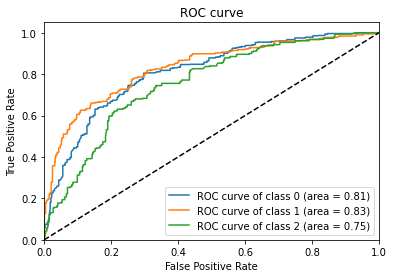

In [ ]:

# performance_metrics(encode, predy_HK)

         _Action  _Romance  _Thriller
1000003     True     False      False
1000006    False     False       True
1000007     True     False      False
1000009    False      True      False
1000011    False     False       True
188/188 ━━━━━━━━━━━━━━━━━━━━ 1209s 6s/step
Confusion Matrix: 
[[1142  290  568]
 [ 246 1308  446]
 [ 375  307 1318]]
Accuracy: 0.628
Precision: 0.633184592331707
Recall: 0.628
F1: 0.628455940909831
AUC: 0.8004307746887207


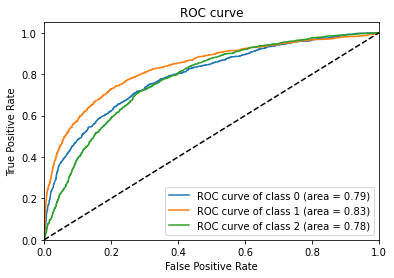

In [47]:
#US

US_df = df[df['country'] == 'USA']
US_df = US_df.drop(columns=['country'])
print(US_df.head())

movie = []
encode = []
n_genre = US_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, US_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = US_df.loc[US_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_US = np.array(movie)
encode_US = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))


# put model onto testing dataset
predy_US = model.predict(movie_US)
predy_class_US = np.argmax(predy_US, axis=1)
truey_class_US = np.argmax(encode_US, axis=1)

performance_metrics(encode_US, predy_US)



         _Action  _Romance  _Thriller
1000033    False     False       True
1000052    False      True      False
1000101     True     False      False
1000142    False      True      False
1000175    False      True      False
188/188 ━━━━━━━━━━━━━━━━━━━━ 1145s 6s/step
Confusion Matrix: 
[[1033  399  568]
 [ 254 1265  481]
 [ 383  482 1135]]
Accuracy: 0.5721666666666667
Precision: 0.5759067660213644
Recall: 0.5721666666666666
F1: 0.5719041749592816
AUC: 0.7566887736320496


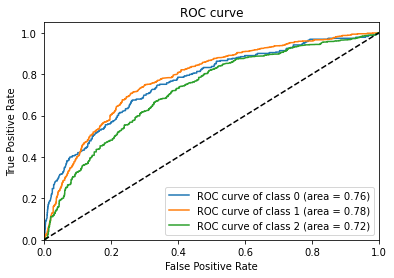

In [52]:
#France

France_df = df[df['country'] == 'France']
France_df = France_df.drop(columns=['country'])
print(France_df.head())

movie = []
encode = []
n_genre = France_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, France_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = France_df.loc[France_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_France = np.array(movie)
encode_France = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))


# put model onto testing dataset
predy_France = model.predict(movie_France)
predy_class_France = np.argmax(predy_France, axis=1)
truey_class_France = np.argmax(encode_France, axis=1)

performance_metrics(encode_France, predy_France)






         _Action  _Romance  _Thriller
1000155    False      True      False
1000255    False      True      False
1000517     True     False      False
1000532    False     False       True
1000541    False     False       True
188/188 ━━━━━━━━━━━━━━━━━━━━ 1136s 6s/step
Confusion Matrix: 
[[1485  311  204]
 [ 328 1491  181]
 [ 633  570  797]]
Accuracy: 0.6288333333333334
Precision: 0.6366593362244027
Recall: 0.6288333333333334
F1: 0.6170089003895098
AUC: 0.8168148398399353
         _Action  _Romance  _Thriller
1000155    False      True      False
1000255    False      True      False
1000517     True     False      False
1000532    False     False       True
1000541    False     False       True
188/188 ━━━━━━━━━━━━━━━━━━━━ 1129s 6s/step
Confusion Matrix: 
[[1485  311  204]
 [ 328 1491  181]
 [ 633  570  797]]
Accuracy: 0.6288333333333334
Precision: 0.6366593362244027
Recall: 0.6288333333333334
F1: 0.6170089003895098
AUC: 0.8168148398399353


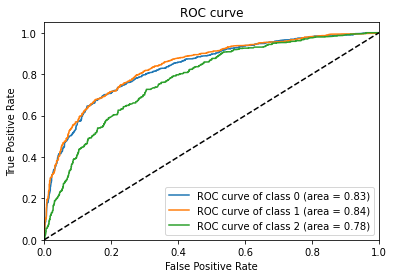

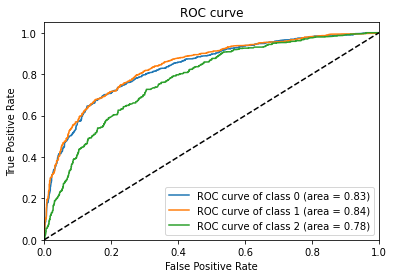

In [53]:
#Japan

Japan_df = df[df['country'] == 'Japan']
Japan_df = Japan_df.drop(columns=['country'])
print(Japan_df.head())

movie = []
encode = []
n_genre = Japan_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, Japan_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Japan_df.loc[Japan_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Japan = np.array(movie)
encode_Japan = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))


# put model onto testing dataset
predy_Japan = model.predict(movie_Japan)
predy_class_Japan = np.argmax(predy_Japan, axis=1)
truey_class_Japan = np.argmax(encode_Japan, axis=1)

performance_metrics(encode_Japan, predy_Japan)



In [ ]:
#India

India_df = df[df['country'] == 'India']
India_df = India_df.drop(columns=['country'])
print(India_df.head())

movie = []
encode = []
n_genre = India_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, India_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = India_df.loc[India_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_India = np.array(movie)
encode_India = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))


# put model onto testing dataset
predy_India = model.predict(movie_India)
predy_class_India = np.argmax(predy_India, axis=1)
truey_class_India = np.argmax(encode_India, axis=1)

performance_metrics(encode_India, predy_India)



Confusion Matrix: 
[[1065  572  363]
 [ 417 1346  237]
 [ 623  451  926]]
Accuracy: 0.5561666666666667
Precision: 0.5603085566643639
Recall: 0.5561666666666667
F1: 0.5534265952999637
AUC: 0.7317928671836853


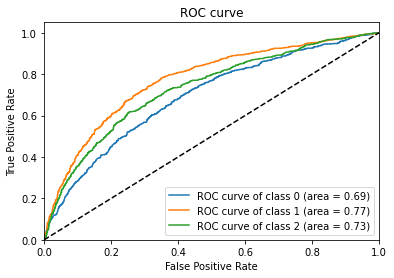

In [179]:
# performance_metrics(encode_India, predy_India)

         _Action  _Romance  _Thriller
1000086     True     False      False
1000391    False      True      False
1000530    False     False       True
1000590    False     False       True
1000633    False     False       True
115/115 ━━━━━━━━━━━━━━━━━━━━ 709s 6s/step
Confusion Matrix: 
[[669 189 364]
 [174 692 356]
 [207 213 802]]
Accuracy: 0.5900163666121113
Precision: 0.5988740765856896
Recall: 0.5900163666121113
F1: 0.5903461978856798
AUC: 0.7624063491821289


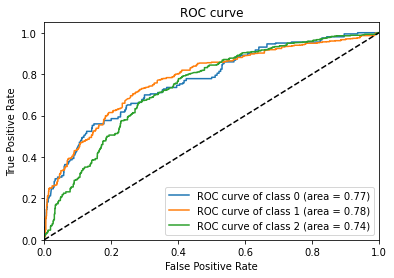

In [183]:
#Spain

Spain_df = df[df['country'] == 'Spain']
Spain_df = Spain_df.drop(columns=['country'])
print(Spain_df.head())

movie = []
encode = []
n_genre = Spain_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, Spain_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = Spain_df.loc[Spain_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_Spain = np.array(movie)
encode_Spain = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_Spain = model.predict(movie_Spain)
predy_class_Spain = np.argmax(predy_Spain, axis=1)
truey_class_Spain = np.argmax(encode_Spain, axis=1)

performance_metrics(encode_Spain, predy_Spain)




         _Action  _Romance  _Thriller
1000017     True     False      False
1000021    False     False       True
1000032    False     False       True
1000044     True     False      False
1000073    False     False       True
188/188 ━━━━━━━━━━━━━━━━━━━━ 1232s 6s/step
Confusion Matrix: 
[[1080  291  629]
 [ 249 1152  599]
 [ 398  345 1257]]
Accuracy: 0.5815
Precision: 0.5918307371070115
Recall: 0.5815
F1: 0.5827754183479673
AUC: 0.7650683522224426


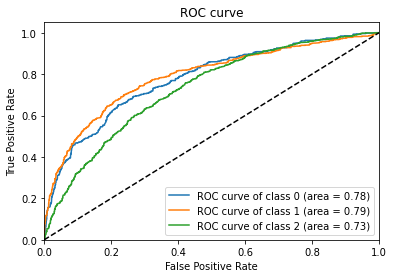

In [182]:
#UK

UK_df = df[df['country'] == 'UK']
UK_df = UK_df.drop(columns=['country'])
print(UK_df.head())

movie = []
encode = []
n_genre = UK_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, UK_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = UK_df.loc[UK_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_UK = np.array(movie)
encode_UK = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_UK = model.predict(movie_UK)
predy_class_UK = np.argmax(predy_UK, axis=1)
truey_class_UK = np.argmax(encode_UK, axis=1)

performance_metrics(encode_UK, predy_UK)




         _Action  _Romance  _Thriller
1000032    False     False       True
1000206    False     False       True
1000259     True     False      False
1000335     True     False      False
1000407    False      True      False
188/188 ━━━━━━━━━━━━━━━━━━━━ 1371s 7s/step
Confusion Matrix: 
[[1570  201  229]
 [ 462 1342  196]
 [ 925  300  775]]
Accuracy: 0.6145
Precision: 0.6349791549599647
Recall: 0.6144999999999999
F1: 0.6054117827336256
AUC: 0.7902541160583496


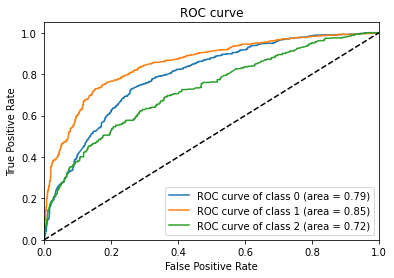

In [180]:
#CHINA

CHINA_df = df[df['country'] == 'China']
CHINA_df = CHINA_df.drop(columns=['country'])
print(CHINA_df.head())

movie = []
encode = []
n_genre = CHINA_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, CHINA_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = CHINA_df.loc[CHINA_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_CHINA = np.array(movie)
encode_CHINA = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_CHINA = model.predict(movie_CHINA)
predy_class_CHINA = np.argmax(predy_CHINA, axis=1)
truey_class_CHINA = np.argmax(encode_CHINA, axis=1)

performance_metrics(encode_CHINA, predy_CHINA)




         _Action  _Romance  _Thriller
1000052    False      True      False
1000073    False     False       True
1001555    False     False       True
1002605    False      True      False
1002952     True     False      False
93/93 ━━━━━━━━━━━━━━━━━━━━ 568s 6s/step
Confusion Matrix: 
[[465 227 292]
 [154 557 273]
 [127 138 719]]
Accuracy: 0.589769647696477
Precision: 0.5958049063963656
Recall: 0.589769647696477
F1: 0.5853603831597808
AUC: 0.7630868554115295


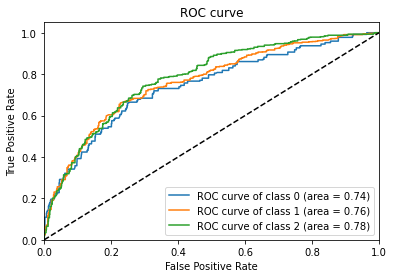

In [181]:
#BRAZIL

BRAZIL_df = df[df['country'] == 'Brazil']
BRAZIL_df = BRAZIL_df.drop(columns=['country'])
print(BRAZIL_df.head())

movie = []
encode = []
n_genre = BRAZIL_df.shape[1]
IMG_SIZE = (345, 230, 3)
size = min(2000, BRAZIL_df.shape[0])

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = BRAZIL_df.loc[BRAZIL_df.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie_BRAZIL = np.array(movie)
encode_BRAZIL = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

# put model onto testing dataset
predy_BRAZIL = model.predict(movie_BRAZIL)
predy_class_BRAZIL = np.argmax(predy_BRAZIL, axis=1)
truey_class_BRAZIL = np.argmax(encode_BRAZIL, axis=1)

performance_metrics(encode_BRAZIL, predy_BRAZIL)



